In [56]:
import os
import glob
from contextlib import ExitStack

import numpy as np
import rasterio
from rasterio.merge import merge
from scipy import stats
import geopandas as gpd
from rasterio import mask as rio_mask
import pandas as pd
import matplotlib.pyplot as plt

import warnings
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import pickle
import sys

sys.path.append("..")
from utils.temporal_analysis import *
from utils import wildfire_powerlaw as wfpl


In [ ]:
# THIS CELL TAKES A VERY LONG TIME TO RUN; THE STATIC RASTER IS SAVED IN
# ../data/static_evt SO YOU ONLY HAVE TO RUN IT ONCE

# THIS MAY HAVE BUGS, I WAS UNABLE TO RUN IT IN TIME SO I PROCEEDED WITH 2024 RASTER ALONE FOR REST OF NOTEBOOK

def _build_static_evt_region(evt_files: list[str], out_path: str) -> str:
    """Compute pixelwise mode across a stack of EVT rasters using block windows."""
    if not evt_files:
        raise ValueError("No EVT rasters provided for region.")

    with ExitStack() as stack:
        srcs = [stack.enter_context(rasterio.open(f)) for f in evt_files]

        ref = srcs[0]
        profile = ref.profile.copy()
        nodata = profile.get("nodata", None)

        profile.update(count=1, compress="lzw")

        if nodata is not None:
            profile["nodata"] = nodata

        with rasterio.open(out_path, "w", **profile) as dst:
            for _, window in ref.block_windows(1):
                block_stack = []
                for src in srcs:
                    arr = src.read(1, window=window).astype("float32")
                    if nodata is not None:
                        arr = np.where(arr == nodata, np.nan, arr)
                    block_stack.append(arr)

                block_stack = np.stack(block_stack, axis=0)
                all_nan = np.isnan(block_stack).all(axis=0)

                mode_block, _ = stats.mode(
                    block_stack, axis=0, nan_policy="omit", keepdims=False
                )
                mode_block = mode_block.astype(profile["dtype"])

                if nodata is not None:
                    mode_block[all_nan] = nodata

                dst.write(mode_block, 1, window=window)

    return out_path


def build_static_evt_us_auto(root_dir: str,
                             out_dir: str = "../data/static_evt") -> dict[str, str]:
    """
    Automatically scans *every subfolder* in root_dir, identifies
    whether it is CONUS or Alaska (based on file name patterns),
    and creates a static EVT map (mode across years) for each region.
    Then mosaics CONUS+AK into one US raster.

    Region detection logic:
       - If file contains 'AK' or 'Alaska': goes to Alaska group
       - Otherwise: goes to CONUS group

    Args:
        root_dir: directory containing all year subfolders.
        out_dir: output directory for the static maps.

    Returns:
        { "conus": <path>, "ak": <path>, "us": <path> }
    """
    os.makedirs(out_dir, exist_ok=True)

    conus_files = []
    ak_files = []

    # Iterate through ALL subfolders
    for item in os.listdir(root_dir):
        folder = os.path.join(root_dir, item)
        if not os.path.isdir(folder):
            continue

        tif_dir = os.path.join(folder, "Tif")
        if not os.path.isdir(tif_dir):
            continue

        tifs = glob.glob(os.path.join(tif_dir, "*.tif"))
        if not tifs:
            continue

        for tif in tifs:
            tif_lower = tif.lower()
            if "ak" in tif_lower or "alaska" in tif_lower:
                ak_files.append(tif)
            else:
                conus_files.append(tif)

    if not conus_files:
        raise RuntimeError("Could not find any CONUS tifs in the dataset.")
    if not ak_files:
        raise RuntimeError("Could not find any Alaska tifs in the dataset.")

    static_conus = os.path.join(out_dir, "static_evt_CONUS.tif")
    static_ak = os.path.join(out_dir, "static_evt_AK.tif")

    static_conus = _build_static_evt_region(conus_files, static_conus)
    static_ak = _build_static_evt_region(ak_files, static_ak)

    us_path = os.path.join(out_dir, "static_evt_US.tif")
    with rasterio.open(static_conus) as src_c, rasterio.open(static_ak) as src_a:
        nodata = src_c.nodata

        mosaic, transform = merge([src_c, src_a], nodata=nodata)

        profile = src_c.profile.copy()
        profile.update(
            height=mosaic.shape[1],
            width=mosaic.shape[2],
            transform=transform,
            dtype=mosaic.dtype,
        )
        if nodata is not None:
            profile["nodata"] = nodata

        with rasterio.open(us_path, "w", **profile) as dst:
            dst.write(mosaic, 1)

    return {"conus": static_conus, "ak": static_ak, "us": us_path}

# REPLACE WITH PATH TO FOLDER THAT CONTAINS ALL FOLDERS DOWNLOADED FROM USDA EVT WEBSITE
# INCLUDING BOTH CONUS AND ALASKA
root_evt_dir = "/Users/lukevonkapff/Desktop/EVT_maps/"
paths = build_static_evt_us_auto(root_evt_dir)
print(paths["us"])


In [2]:
mtbs_gdf = gpd.read_file("../data/mtbs_classified.shp")

mtbs_gdf = mtbs_gdf.rename(columns={
    "modis_cl": "modis_class_timevary",
    "modis_cl_1": "modis_class_static",
    "biome_refi": "modis_class_static_grouped",
})

mtbs_gdf.head()

,FIRE_ID,FIRE_NAME,year,STARTMONTH,STARTDAY,FIRE_TYPE,ACRES,IRWINID,MAP_ID,MAP_PROG,...,COMMENTS,LATITUDE,LONGITUDE,SHAPE_AREA,SHAPE_LEN,area_km2,modis_clas,modis_class_static,modis_class_static_grouped,geometry
0,VA3759307943320231113,MATTS CREEK,2023,11,13,Wildfire,11028.0,586FAE9C-A77A-4F72-8C7B-59C83AB1774A,10032065,MTBS,...,None,37.590,-79.442,0.004554,0.377378,44.643475,Unknown,Deciduous Broadleaf forest,Deciduous Broadleaf forest,"POLYGON ((-7666374.111 4463932.733, -7666364.8..."
1,AR3566809361520240218,RX FULLY SUCCESSFUL,2024,2,18,Prescribed Fire,1260.0,E883508D-33D2-4867-81F6-ADDB41DD4533,10032199,MTBS,...,None,35.656,-93.624,0.000507,0.126526,5.092698,Unknown,Deciduous Broadleaf forest,Deciduous Broadleaf forest,"POLYGON ((-9032754.112 4265643.644, -9032813.3..."
2,AR3461409347120240225,RX LITTLE FIR 12 AND 16,2024,2,25,Prescribed Fire,1341.0,C47DB3AD-B702-406D-AE56-7DDAE3C8D869,10032264,MTBS,...,None,34.617,-93.489,0.000532,0.192862,5.410062,Unknown,Deciduous Broadleaf forest,Deciduous Broadleaf forest,"POLYGON ((-9022046.486 4157443.28, -9022135.77..."
3,NY4117507430420241108,JENNINGS CREEK,2024,11,8,Wildfire,5069.0,4CEF1278-C388-44FD-9458-C4AA48070693,10032269,MTBS,...,None,41.177,-74.294,0.002197,0.303595,20.471479,Unknown,Deciduous Broadleaf forest,Deciduous Broadleaf forest,"POLYGON ((-7170321.494 4819741.697, -7170304.9..."
4,AL3376308561020240413,SCK RATTLE SNAKE J-K-L-M RX,2024,4,13,Prescribed Fire,2510.0,F54EA672-4975-4902-B0D8-43F3018EE0B0,10030727,MTBS,...,Includes RATTLESNAKE K fire (AL337590856132024...,33.764,-85.610,0.000988,0.173612,10.152238,Unknown,Deciduous Broadleaf forest,Deciduous Broadleaf forest,"POLYGON ((-8260359.765 4066446.237, -8260449.8..."


In [21]:
def classify_fire_evt_2024(
    fires_gdf: gpd.GeoDataFrame,
    conus_raster_path: str,
    alaska_raster_path: str,
    column_name: str = "EVT_class",
) -> gpd.GeoDataFrame:
    """
    Classify each fire polygon using the most common EVT category found
    in the 2024 CONUS + 2024 Alaska EVT rasters.

    Assumptions:
      - fires_gdf.geometry has a valid CRS (e.g., EPSG:6933 for MTBS)
      - CONUS and AK rasters may have different projected CRSs
    """
    if "geometry" not in fires_gdf:
        raise ValueError("fires_gdf must contain a geometry column.")
    if fires_gdf.crs is None:
        raise ValueError("fires_gdf must have a CRS set (fires_gdf.crs).")

    fires_out = fires_gdf.copy()

    with rasterio.open(conus_raster_path) as src_conus, rasterio.open(alaska_raster_path) as src_ak:
        # Reproject fires to each raster's CRS
        fires_conus = fires_out.to_crs(src_conus.crs)
        fires_ak = fires_out.to_crs(src_ak.crs)

        evt_vals: list[float] = []

        for geom_conus, geom_ak in zip(fires_conus.geometry, fires_ak.geometry):
            # Skip empty geometries
            if geom_conus is None or geom_conus.is_empty:
                evt_vals.append(np.nan)
                continue

            got_value = False

            # -----------------------
            # Try CONUS raster first
            # -----------------------
            try:
                out_image, _ = rio_mask.mask(src_conus, [geom_conus], crop=True)
                arr = out_image[0]

                nod = src_conus.nodata
                if nod is not None:
                    arr = arr[arr != nod]

                if arr.size > 0:
                    vals, counts = np.unique(arr, return_counts=True)
                    mode_val = vals[np.argmax(counts)]
                    evt_vals.append(int(mode_val))
                    got_value = True
            except ValueError:
                # Polygon outside CONUS raster extent
                pass

            if got_value:
                continue

            # -----------------------
            # Try Alaska raster
            # -----------------------
            try:
                out_image, _ = rio_mask.mask(src_ak, [geom_ak], crop=True)
                arr = out_image[0]

                nod = src_ak.nodata
                if nod is not None:
                    arr = arr[arr != nod]

                if arr.size > 0:
                    vals, counts = np.unique(arr, return_counts=True)
                    mode_val = vals[np.argmax(counts)]
                    evt_vals.append(int(mode_val))
                    got_value = True
            except ValueError:
                # Polygon outside Alaska raster extent
                pass

            if not got_value:
                evt_vals.append(np.nan)

    fires_out[column_name] = evt_vals
    return fires_out

conus_2024 = "/Users/lukevonkapff/Desktop/EVT_maps/LF2024_EVT_250_CONUS/Tif/LC24_EVT_250.tif"
alaska_2024 = "/Users/lukevonkapff/Desktop/EVT_maps/LF2024_EVT_250_AK/Tif/LA24_EVT_250.tif"

fires_with_evt = classify_fire_evt_2024(
    fires_gdf=mtbs_gdf,
    conus_raster_path=conus_2024,
    alaska_raster_path=alaska_2024,
    column_name="EVT_class",
)


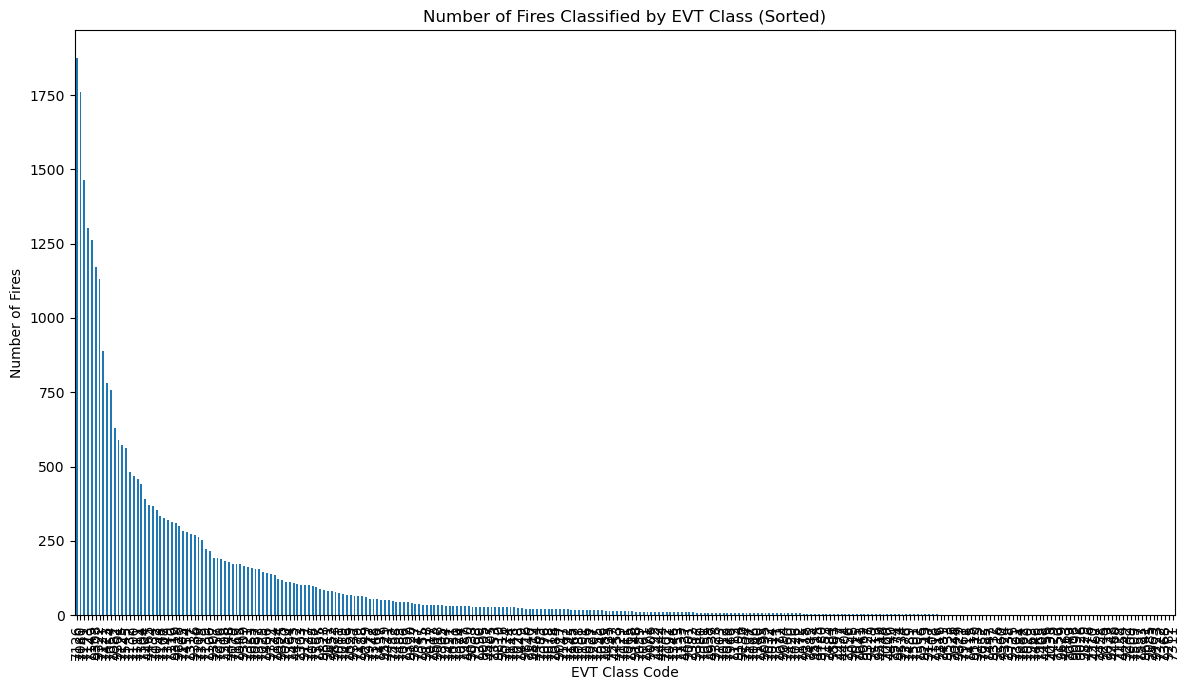

In [24]:
counts = fires_with_evt["EVT_class"].value_counts(dropna=False).sort_values(ascending=False)

plt.figure(figsize=(12, 7))
counts.plot(kind="bar")

plt.xlabel("EVT Class Code")
plt.ylabel("Number of Fires")
plt.title("Number of Fires Classified by EVT Class (Sorted)")
plt.tight_layout()
plt.show()


In [33]:
counts = fires_with_evt["EVT_class"].dropna().value_counts()
num_categories_over_400 = (counts > 400).sum()
print(f"Number of EVT categories with >100 fires: {num_categories_over_400}")

Number of EVT categories with >100 fires: 18


In [29]:
# REPLACE WITH PATH TO ATTRIBUTE TABLE CSV
attribute_key = pd.read_csv("/Users/lukevonkapff/Desktop/LF2024_EVT.csv")

mtbs = fires_with_evt.merge(
    attribute_key,
    how="left",
    left_on="EVT_class",
    right_on="VALUE"
)

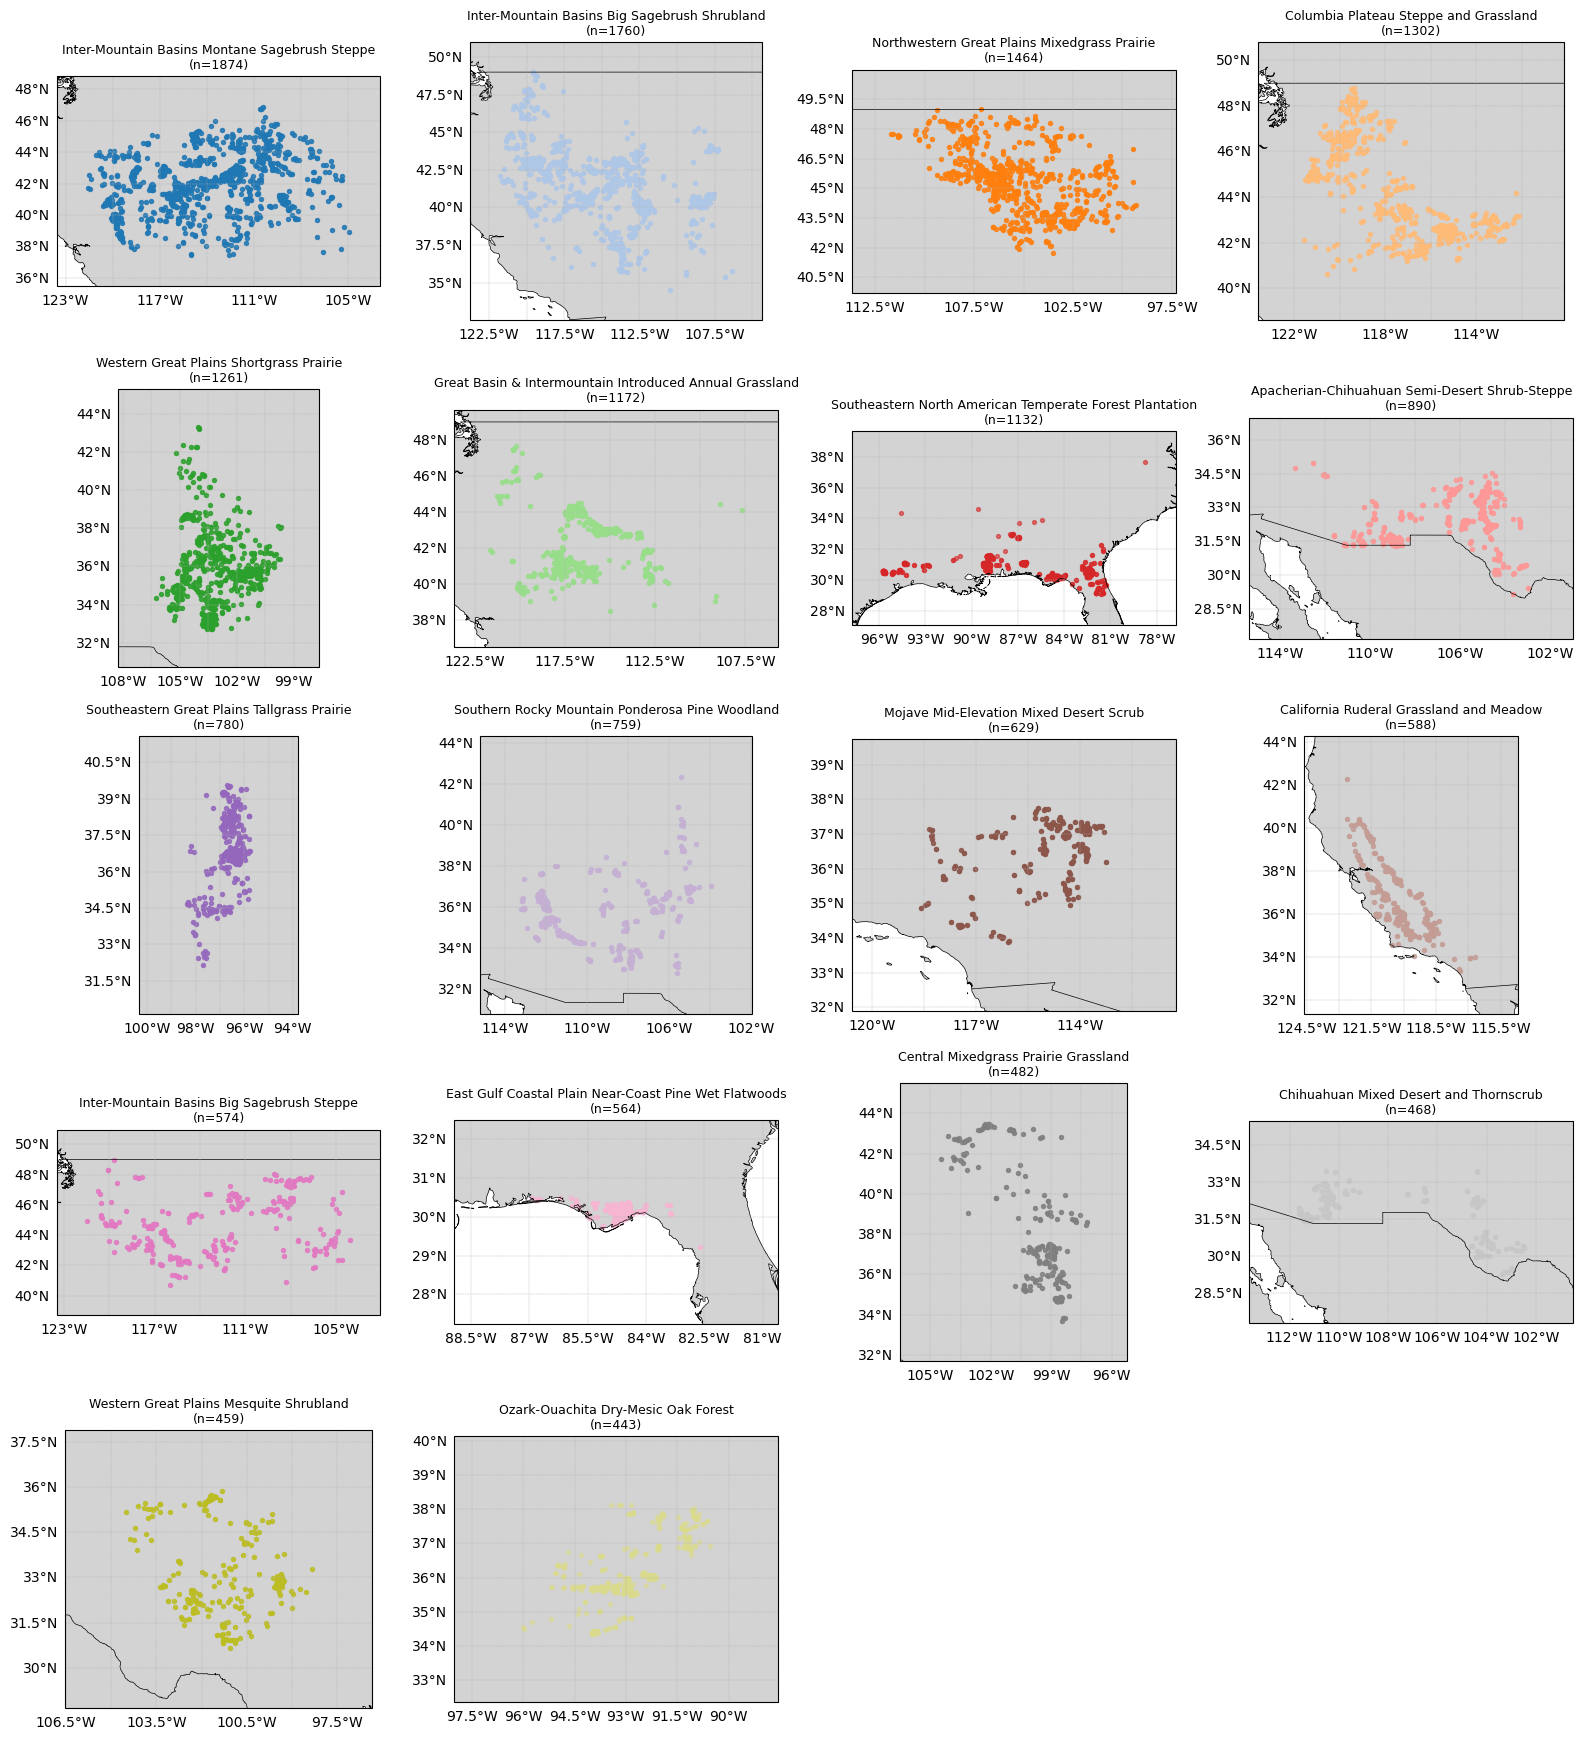

In [41]:
def plot_evtname_facets(
    fires_evt: gpd.GeoDataFrame | pd.DataFrame,
    col_name: str,
    min_fires: int = 400,
) -> None:
    """
    Create a faceted map of MTBS fire locations for EVT_NAME classes
    that have more than `min_fires` fires (e.g., >400).

    Each panel shows fire centroids (LAT/LONG) for one EVT_NAME.
    """
    warnings.filterwarnings("ignore", category=RuntimeWarning)

    df = fires_evt.copy()
    df = df[df[col_name].notna()].copy()
    df = df[df["LATITUDE"].apply(np.isfinite) & df["LONGITUDE"].apply(np.isfinite)]

    if df.empty:
        print("No valid fire locations found for plotting.")
        return

    counts = df[col_name].value_counts()
    top_evts = counts[counts > min_fires].index.tolist()

    if not top_evts:
        print(f"No categories with more than {min_fires} fires.")
        return

    top_evts = sorted(top_evts, key=lambda name: counts[name], reverse=True)

    if not isinstance(df, gpd.GeoDataFrame):
        df = gpd.GeoDataFrame(
            df,
            geometry=gpd.points_from_xy(df.LONGITUDE, df.LATITUDE),
            crs="EPSG:4326",
        )

    df = df[df.geometry.notna() & (~df.geometry.is_empty) & df.geometry.is_valid].copy()
    if df.empty:
        print("No valid fire geometries after cleaning.")
        return

    n = len(top_evts)
    ncols = 4
    nrows = int(np.ceil(n / ncols))

    fig, axes = plt.subplots(
        nrows,
        ncols,
        figsize=(4 * ncols, 3.5 * nrows),
        subplot_kw={"projection": ccrs.PlateCarree()},
    )

    if isinstance(axes, np.ndarray):
        axes_flat = axes.ravel()
    else:
        axes_flat = [axes]

    cmap = plt.get_cmap("tab20")
    colors = {name: cmap(i % cmap.N) for i, name in enumerate(top_evts)}

    for ax, evt_name in zip(axes_flat, top_evts):
        subset = df[df[col_name] == evt_name].copy()

        ax.add_feature(cfeature.LAND, facecolor="lightgrey")
        ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
        ax.add_feature(cfeature.BORDERS, linewidth=0.5)

        if subset.empty:
            ax.set_title(f"{evt_name}\n(no data)", fontsize=9, pad=6)
            ax.set_extent([-170, -50, 15, 75], crs=ccrs.PlateCarree())
        else:
            ax.scatter(
                subset["LONGITUDE"],
                subset["LATITUDE"],
                color=colors[evt_name],
                s=8,
                alpha=0.6,
                transform=ccrs.PlateCarree(),
            )

            try:
                minx, miny, maxx, maxy = subset[["LONGITUDE", "LATITUDE"]].agg(
                    ["min", "max"]
                ).values.ravel()
                pad_x = max((maxx - minx) * 0.05, 2)
                pad_y = max((maxy - miny) * 0.05, 2)
                ax.set_extent(
                    [minx - pad_x, maxx + pad_x, miny - pad_y, maxy + pad_y],
                    crs=ccrs.PlateCarree(),
                )
            except Exception:
                ax.set_extent([-170, -50, 15, 75], crs=ccrs.PlateCarree())

            count_here = counts[evt_name]
            ax.set_title(f"{evt_name}\n(n={count_here})", fontsize=9, pad=6)

        gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.3)
        gl.top_labels = False
        gl.right_labels = False

    if len(top_evts) < len(axes_flat):
        for ax in axes_flat[len(top_evts) :]:
            ax.set_visible(False)

    plt.tight_layout()
    plt.show()

plot_evtname_facets(mtbs, min_fires=400, col_name = "EVT_NAME")

In [47]:
mtbs.columns

Index(['FIRE_ID', 'FIRE_NAME', 'year', 'STARTMONTH', 'STARTDAY', 'FIRE_TYPE',
       'ACRES', 'IRWINID', 'MAP_ID', 'MAP_PROG', 'ASMNT_TYPE', 'IG_DATE',
       'PRE_ID', 'POST_ID', 'PERIM_ID', 'DNBR_OFFST', 'DNBR_STDDV',
       'NODATA_THR', 'GREENNESS_', 'LOW_THRESH', 'MODERATE_T', 'HIGH_THRES',
       'COMMENTS', 'LATITUDE', 'LONGITUDE', 'SHAPE_AREA', 'SHAPE_LEN',
       'area_km2', 'modis_clas', 'modis_class_static',
       'modis_class_static_grouped', 'geometry', 'EVT_class', 'VALUE',
       'EVT_NAME', 'LFRDB', 'EVT_FUEL', 'EVT_FUEL_N', 'EVT_LF', 'EVT_PHYS',
       'EVT_GP', 'EVT_GP_N', 'SAF_SRM', 'EVT_ORDER', 'EVT_CLASS', 'EVT_SBCLS',
       'R', 'G', 'B', 'RED', 'GREEN', 'BLUE'],
      dtype='object')

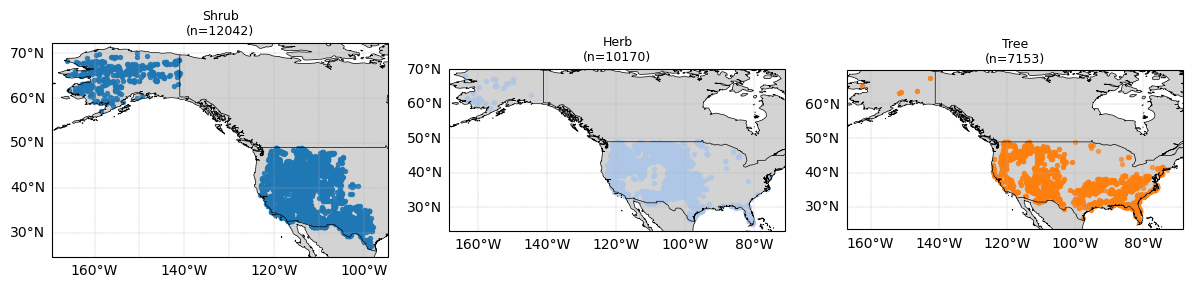

In [50]:
plot_evtname_facets(mtbs, min_fires=400, col_name = "EVT_LF")

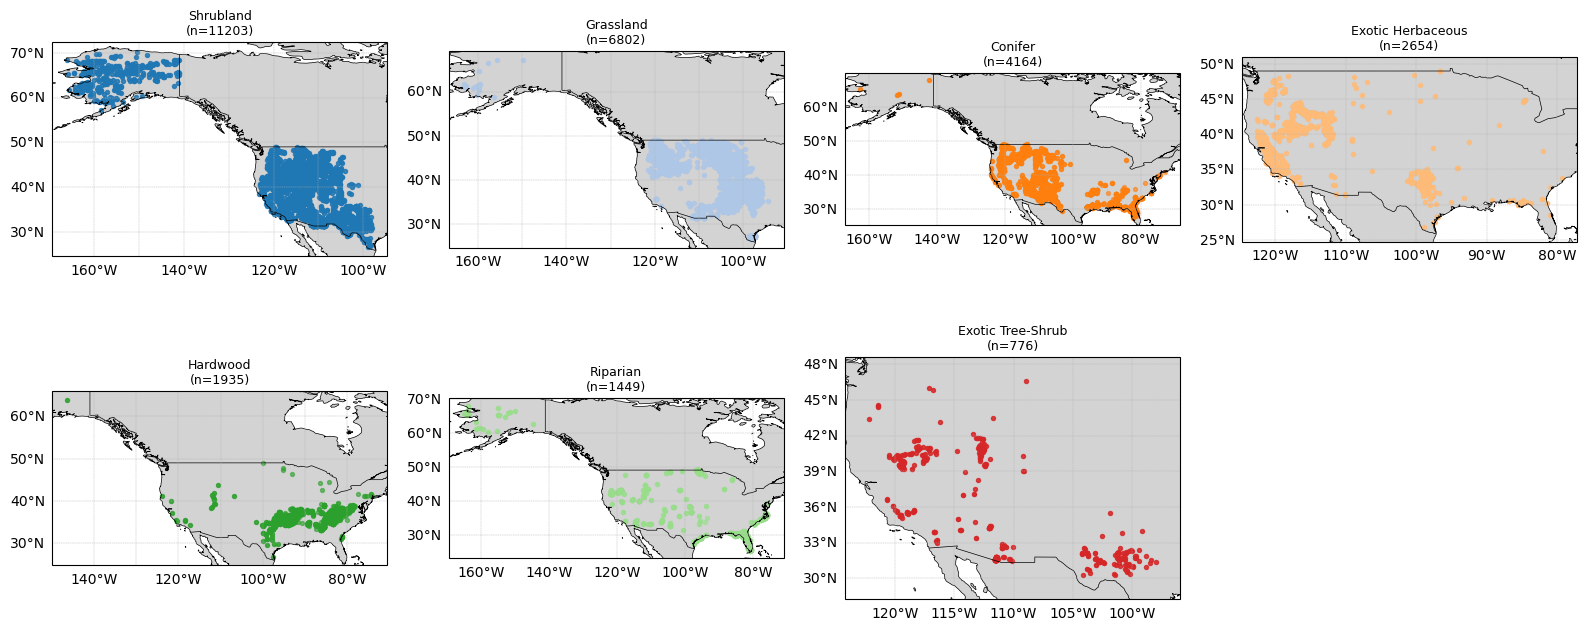

In [51]:
plot_evtname_facets(mtbs, min_fires=400, col_name = "EVT_PHYS")

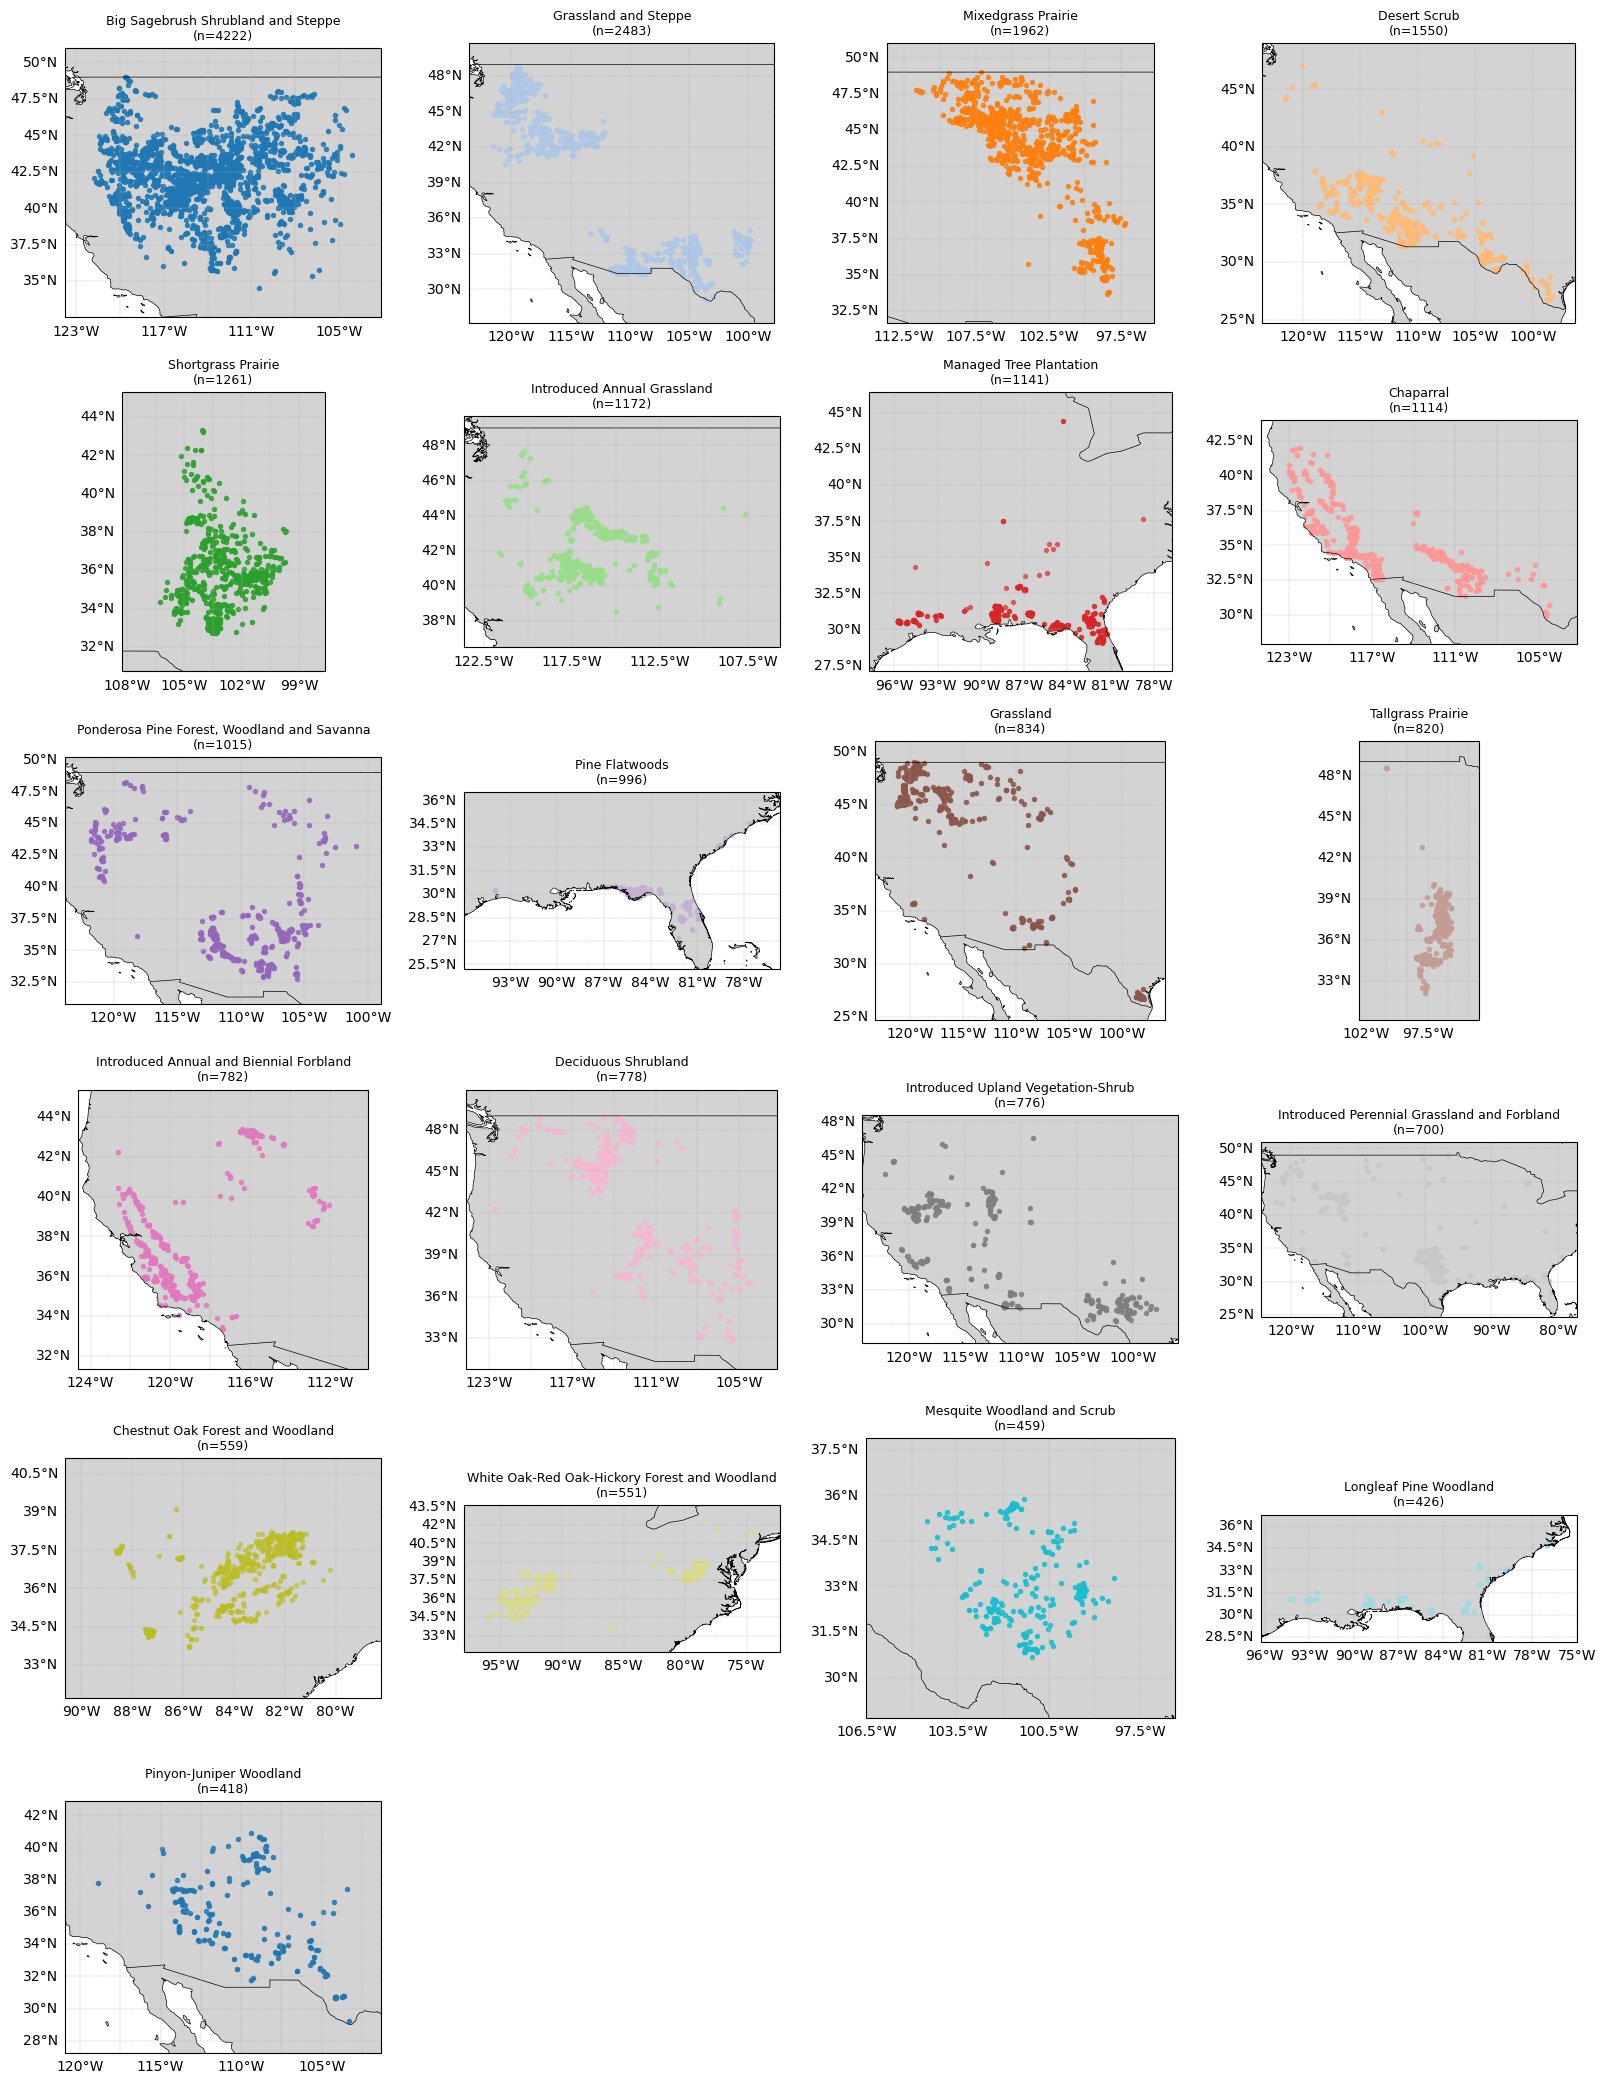

In [53]:
plot_evtname_facets(mtbs, min_fires=400, col_name = "EVT_GP_N")

In [57]:
xmin = 4
min_total_evt = 400  # only fit EVT_NAME groups with ≥ 400 fires total

overall_results_evt = {}

for evt_name, subset in mtbs.groupby("EVT_NAME"):
    data = subset["area_km2"].values
    if len(data) < min_total_evt:
        print(f"⚠️ Skipping {evt_name} (only {len(data)} fires)")
        continue

    print(f"\n=== {evt_name} (n={len(data)}) ===")
    params = wfpl.summarize_parameters_bootstrap(
        data, R=50, xmin=xmin, random_state=42
    )
    R_mat, best = wfpl.likelihood_matrix_and_best(data, xmin=xmin)

    overall_results_evt[evt_name] = {
        "params": params,
        "likelihood_matrix": R_mat,
        "best_fit": best,
    }

SAVE_PATH_EVT = "../data/overall_results_evtname.pkl"
with open(SAVE_PATH_EVT, "wb") as f:
    pickle.dump(overall_results_evt, f)

print(f"\nSaved EVT_NAME static fits to: {SAVE_PATH_EVT}")

⚠️ Skipping Alabama Ketona Glade and Woodland (only 2 fires)
⚠️ Skipping Alaska Arctic Mesic Alder Shrubland (only 4 fires)
⚠️ Skipping Alaska Arctic Permafrost Plateau Dwarf-Shrub Lichen Tundra (only 28 fires)
⚠️ Skipping Alaskan Pacific-Aleutian Alder-Salmonberry-Copperbush Shrubland (only 4 fires)
⚠️ Skipping Aleutian Ericaceous Dwarf-shrubland Heath and Fell-field (only 2 fires)
⚠️ Skipping Allegheny-Cumberland Dry Oak Forest and Woodland (only 273 fires)
⚠️ Skipping Apacherian-Chihuahuan Semi-Desert Grassland (only 191 fires)

=== Apacherian-Chihuahuan Semi-Desert Shrub-Steppe (n=890) ===
there are 890 points above xmin 4.0 km^2
⚠️ Skipping Arkansas Valley Prairie (only 2 fires)
⚠️ Skipping Atlantic Coastal Plain Embayed Region Tidal Salt and Brackish Marsh (only 4 fires)
⚠️ Skipping Atlantic Coastal Plain Fall-line Sandhills Longleaf Pine Woodland (only 10 fires)
⚠️ Skipping Atlantic Coastal Plain Peatland Pocosin and Canebrake Woodland (only 80 fires)
⚠️ Skipping Atlantic Coasta

In [58]:
def analyze_time_varying_mle_evtname(
    mtbs_evt: pd.DataFrame | gpd.GeoDataFrame,
    overall_results: dict,
    group_col: str = "EVT_NAME",
    year_col: str = "year",
    xmin: float = 4,
    llhr_cutoff: float = 2.0,
    R_boot: int = 20,
    min_total: int = 400,
    verbose: bool = True,
    prior_weight: float = 1e-3,
) -> dict:
    """Time-varying MLE with Differential Evolution for EVT_NAME groupings.

    This mirrors `analyze_time_varying_mle_refined` but uses EVT_NAME (or any
    other grouping column) directly as the group identifier.

    Args:
        mtbs_evt: Fire records with columns including `group_col`, `year_col`, and `area_km2`.
        overall_results: Static fit results per group, with entries:
            overall_results[group]['params'] (DataFrame)
            overall_results[group]['likelihood_matrix'] (DataFrame)
        group_col: Column used to define groups (e.g., 'EVT_NAME').
        year_col: Name of the year column.
        xmin: Minimum size threshold (km²) for the tail analysis.
        llhr_cutoff: Δlog-likelihood threshold for filtering candidate dists.
        R_boot: Number of bootstrap replicates for SE estimation.
        min_total: Minimum number of tail observations per group.
        verbose: If True, print progress and filtering diagnostics.
        prior_weight: Strength of weak Gaussian prior on transformed parameters.

    Returns:
        Nested dict: results[group][dist_name][mode] with keys:
          - "coeffs": transformed coefficients (p1, p1', p2, p2') or subset
          - "ses": bootstrap SEs for the transformed coefficients
          - "loglik": best penalized log-likelihood
          - "n": number of tail observations used for this group
    """
    import warnings
    import numpy as np
    import pandas as pd
    from scipy.optimize import differential_evolution
    from scipy.special import gamma, gammaincc

    warnings.filterwarnings("ignore", category=RuntimeWarning)

    df = mtbs_evt.copy()

    # We only care about groups present in overall_results (i.e. those with static fits)
    valid_groups = set(overall_results.keys())
    df = df[df[group_col].isin(valid_groups)].copy()

    # Center years (decades) for time-varying parameterization
    df["year_c"] = (df[year_col] - df[year_col].mean()) / 10.0

    if verbose:
        print("\nGroup counts for time-varying MLE (by", group_col, "):")
        print(df[group_col].value_counts())

    # ----------------------------------------------------------------------
    # Log-PDFs (unchanged from your refined version)
    # ----------------------------------------------------------------------
    def logpdf_lognormal(x, mu, sigma, xmin=0):
        x = np.asarray(x)
        valid = x > xmin
        pdf = -np.inf * np.ones_like(x, dtype=float)
        sigma = np.clip(sigma, 1e-6, 50)
        pdf[valid] = (
            -np.log(x[valid]) - np.log(sigma)
            - 0.5 * ((np.log(x[valid]) - mu) / sigma) ** 2
            - np.log(np.sqrt(2 * np.pi))
        )
        return pdf

    def logpdf_powerlaw(x, alpha, xmin=1):
        x = np.asarray(x)
        valid = x >= xmin
        pdf = -np.inf * np.ones_like(x, dtype=float)
        alpha = np.clip(alpha, 0.0, 5)
        C = (alpha - 1) / xmin if alpha != 1 else 1 / xmin
        pdf[valid] = np.log(np.abs(C)) - alpha * np.log(x[valid] / xmin)
        return pdf

    def logpdf_trunc_powerlaw(x, alpha, lambd, xmin=1):
        x = np.asarray(x)
        valid = x >= xmin
        pdf = -np.inf * np.ones_like(x, dtype=float)
        alpha = np.clip(alpha, 0, 5)
        lambd = np.clip(lambd, 0, 5)
        try:
            Z = (
                (lambd ** (1 - alpha))
                * np.exp(lambd * xmin)
                * gammaincc(1 - alpha, lambd * xmin)
                * gamma(1 - alpha)
            )
            Z = np.clip(Z, 1e-300, 1e300)
            logZ = np.log(Z)
        except Exception:
            logZ = 0.0
        pdf[valid] = -alpha * np.log(x[valid]) - lambd * (x[valid] - xmin) - logZ
        return pdf

    def logpdf_genpareto(x, xi, sigma, xmin=0):
        x = np.asarray(x)
        y = x - xmin
        valid = (sigma > 0) & (1 + xi * y / sigma > 0)
        pdf = -np.inf * np.ones_like(x, dtype=float)
        xi = np.clip(xi, -1, 2)
        sigma = np.clip(sigma, 1e-6, 10)
        pdf[valid] = -np.log(sigma) - (1 / xi + 1) * np.log(1 + xi * y[valid] / sigma)
        return pdf

    def logpdf_weibull(x, k, lam, xmin=0):
        x = np.asarray(x)
        valid = x >= xmin
        pdf = -np.inf * np.ones_like(x, dtype=float)
        k = np.clip(k, 1e-6, 50)
        lam = np.clip(lam, 1e-6, 50)
        z = np.clip(x[valid] / lam, 1e-12, 1e6)
        pdf[valid] = np.log(k) - np.log(lam) + (k - 1) * np.log(z) - z ** k
        return pdf

    def logpdf_stretched_exp(x, lam, beta, xmin=0):
        x = np.asarray(x)
        valid = x >= xmin
        pdf = -np.inf * np.ones_like(x, dtype=float)
        lam = np.clip(lam, 1e-6, 50)
        beta = np.clip(beta, 0.1, 5)
        pdf[valid] = (
            np.log(beta)
            + np.log(lam)
            + (beta - 1) * (np.log(x[valid]) + np.log(lam))
            + (lam * xmin) ** beta
            - (lam * x[valid]) ** beta
        )
        return pdf

    dist_logpdfs = {
        "lognormal": logpdf_lognormal,
        "power_law": logpdf_powerlaw,
        "truncated_power_law": logpdf_trunc_powerlaw,
        "generalized_pareto": logpdf_genpareto,
        "weibull": logpdf_weibull,
        "stretched_exponential": logpdf_stretched_exp,
    }

    # ----------------------------------------------------------------------
    # Time-varying fits per EVT_NAME (or group_col)
    # ----------------------------------------------------------------------
    timevary_results = {}
    rng_global = np.random.default_rng(42)

    for group, subset in df.groupby(group_col):
        data_all = subset["area_km2"].values
        data = data_all[data_all >= xmin]

        if len(data) < min_total:
            if verbose:
                print(f"\n=== {group} skipped: only {len(data)} fires ≥ {xmin} ===")
            continue

        years = subset.loc[subset["area_km2"] >= xmin, "year_c"].values

        if verbose:
            print(f"\n=== {group} (n={len(data)} fires ≥ {xmin}) ===")

        res = overall_results.get(group, {})
        if not res:
            if verbose:
                print(f"No static results found for {group}")
            continue

        params_df = res["params"]
        llhr = res["likelihood_matrix"]

        # Candidate distributions
        candidates = []
        for dist, row in params_df.iterrows():
            if dist not in dist_logpdfs:
                continue
            if isinstance(row.get("reduces_to"), str):
                continue
            if dist in llhr.index and llhr.loc[dist].min() > llhr_cutoff:
                continue
            candidates.append(dist)

        if not candidates:
            if verbose:
                print(f"No viable candidates for {group}")
            continue

        group_res = {}

        for dist_name in candidates:
            fit_modes = {}
            fit_configs = {"both": [True, True], "p1_only": [True, False], "p2_only": [False, True]}

            static_row = params_df.loc[dist_name]
            p1_static = float(static_row.get("p1", 1.0))
            p2_static = float(static_row.get("p2", 1.0)) if not pd.isna(static_row.get("p2", np.nan)) else 1.0

            for mode, (fit_p1, fit_p2) in fit_configs.items():

                def neg_loglik(params, data=data):
                    try:
                        # unpack
                        if dist_name == "truncated_power_law":
                            if mode == "both":
                                a1, b1, a2, b2 = params
                            elif mode == "p1_only":
                                a1, b1, a2 = params
                                b2 = 0.0
                            elif mode == "p2_only":
                                a1, a2, b2 = params
                                b1 = 0.0
                        else:
                            if mode == "both":
                                a1, b1, a2, b2 = params
                            elif mode == "p1_only":
                                a1, b1, a2 = params
                                b2 = 0.0
                            elif mode == "p2_only":
                                a1, a2, b2 = params
                                b1 = 0.0

                        # time-varying params
                        if dist_name == "truncated_power_law":
                            alpha = 1.0 + np.exp(a1 + b1 * years)
                            lambd = np.exp(a2 + b2 * years)
                            ll = logpdf_trunc_powerlaw(data, alpha, lambd, xmin)
                        elif dist_name == "lognormal":
                            mu = a1 + b1 * years
                            sigma = np.clip(a2 + b2 * years, 1e-6, 50)
                            ll = logpdf_lognormal(data, mu, sigma, xmin)
                        elif dist_name == "generalized_pareto":
                            xi = np.clip(a1 + b1 * years, -1, 2)
                            sigma = np.clip(a2 + b2 * years, 1e-6, 10)
                            ll = logpdf_genpareto(data, xi, sigma, xmin)
                        elif dist_name == "power_law":
                            alpha = np.clip(a1 + b1 * years, 0.0, 5)
                            ll = logpdf_powerlaw(data, alpha, xmin)
                        elif dist_name == "weibull":
                            k = np.clip(a1 + b1 * years, 1e-3, 10)
                            lam = np.clip(a2 + b2 * years, 1e-3, 50)
                            ll = logpdf_weibull(data, k, lam, xmin)
                        elif dist_name == "stretched_exponential":
                            lam = np.clip(a1 + b1 * years, 1e-4, 50)
                            beta = np.clip(a2 + b2 * years, 0.1, 5)
                            ll = logpdf_stretched_exp(data, lam, beta, xmin)
                        else:
                            return np.inf

                        valid_ll = ll[np.isfinite(ll)]

                        # weak prior around static parameters
                        if dist_name == "truncated_power_law":
                            prior_center_a1 = np.log(max(p1_static - 1, 1e-3))
                        else:
                            prior_center_a1 = np.log(max(p1_static, 1e-6))
                        prior_center_a2 = np.log(max(p2_static, 1e-6))
                        prior_penalty = prior_weight * (
                            (a1 - prior_center_a1) ** 2 + (a2 - prior_center_a2) ** 2
                        )
                        return -np.sum(valid_ll) + prior_penalty
                    except Exception:
                        return np.inf

                # bounds
                if dist_name == "truncated_power_law":
                    bounds = [(-2, 2), (-1, 1), (-9, 0), (-1, 1)]
                elif dist_name == "generalized_pareto":
                    bounds = [(-1, 2), (-1, 1), (1e-6, 10), (-1, 1)]
                elif dist_name == "power_law":
                    bounds = [(0.0, 5), (-1, 1)]
                elif dist_name == "weibull":
                    bounds = [(1e-3, 10), (-1, 1), (1e-3, 50), (-1, 10)]
                elif dist_name == "stretched_exponential":
                    bounds = [(1e-4, 50), (-1, 1), (0.1, 5), (-1, 1)]
                else:
                    bounds = [(-5, 5), (-1, 1), (-5, 5), (-1, 1)]

                if mode == "both":
                    bnds = bounds
                elif mode == "p1_only":
                    bnds = [bounds[0], bounds[1], bounds[2]]
                elif mode == "p2_only":
                    bnds = [bounds[0], bounds[2], bounds[3]]

                opt = differential_evolution(
                    neg_loglik,
                    bounds=bnds,
                    strategy="best1bin",
                    maxiter=600,
                    popsize=15,
                    polish=True,
                    seed=42,
                    updating="deferred",
                    workers=1,
                    init="latinhypercube",
                )
                coeffs = opt.x
                ll_max = -opt.fun

                # bootstrap
                boot_params = []
                for _ in range(R_boot):
                    idx = rng_global.choice(len(data), size=len(data), replace=True)
                    boot_data = data[idx]
                    try:
                        opt_b = differential_evolution(
                            lambda p: neg_loglik(p, data=boot_data),
                            bounds=bnds,
                            maxiter=300,
                            polish=False,
                            seed=None,
                            updating="deferred",
                            workers=1,
                        )
                        boot_params.append(opt_b.x)
                    except Exception:
                        continue

                # transform for truncated power law
                if dist_name == "truncated_power_law":
                    if mode == "both":
                        a1, b1, a2, b2 = coeffs
                    elif mode == "p1_only":
                        a1, b1, a2 = coeffs
                        b2 = 0.0
                    elif mode == "p2_only":
                        a1, a2, b2 = coeffs
                        b1 = 0.0

                    p1 = 1 + np.exp(a1)
                    p1p = b1 * np.exp(a1)
                    p2 = np.exp(a2)
                    p2p = b2 * np.exp(a2)

                    if boot_params:
                        boot_p1, boot_p1p, boot_p2, boot_p2p = [], [], [], []
                        for bp in boot_params:
                            if mode == "both":
                                ba1, bb1, ba2, bb2 = bp
                            elif mode == "p1_only":
                                ba1, bb1, ba2 = bp
                                bb2 = 0.0
                            elif mode == "p2_only":
                                ba1, ba2, bb2 = bp
                                bb1 = 0.0
                            boot_p1.append(1 + np.exp(ba1))
                            boot_p1p.append(bb1 * np.exp(ba1))
                            boot_p2.append(np.exp(ba2))
                            boot_p2p.append(bb2 * np.exp(ba2))
                        p1_se, p1p_se = np.std(boot_p1), np.std(boot_p1p)
                        p2_se, p2p_se = np.std(boot_p2), np.std(boot_p2p)
                    else:
                        p1_se = p1p_se = p2_se = p2p_se = 0.0

                    coeffs_trans = [p1, p1p, p2, p2p]
                    ses_trans = [p1_se, p1p_se, p2_se, p2p_se]
                else:
                    ses = np.std(boot_params, axis=0) if boot_params else np.zeros_like(coeffs)
                    coeffs_trans = coeffs
                    ses_trans = ses

                fit_modes[mode] = {
                    "coeffs": coeffs_trans,
                    "ses": ses_trans,
                    "loglik": ll_max,
                    "n": len(data),
                }

            if fit_modes:
                group_res[dist_name] = fit_modes

        if group_res:
            timevary_results[group] = group_res

    return timevary_results

timevary_results_evt = analyze_time_varying_mle_evtname(
    mtbs_evt=mtbs,        
    overall_results=overall_results_evt,
    group_col="EVT_NAME",
    xmin=4,
    min_total=400,
)


Group counts for time-varying MLE (by EVT_NAME ):
EVT_NAME
Inter-Mountain Basins Montane Sagebrush Steppe             1874
Inter-Mountain Basins Big Sagebrush Shrubland              1760
Northwestern Great Plains Mixedgrass Prairie               1464
Columbia Plateau Steppe and Grassland                      1302
Western Great Plains Shortgrass Prairie                    1261
Great Basin & Intermountain Introduced Annual Grassland    1172
Southeastern North American Temperate Forest Plantation    1132
Apacherian-Chihuahuan Semi-Desert Shrub-Steppe              890
Southeastern Great Plains Tallgrass Prairie                 780
Southern Rocky Mountain Ponderosa Pine Woodland             759
Mojave Mid-Elevation Mixed Desert Scrub                     629
California Ruderal Grassland and Meadow                     588
Inter-Mountain Basins Big Sagebrush Steppe                  574
East Gulf Coastal Plain Near-Coast Pine Wet Flatwoods       564
Central Mixedgrass Prairie Grassland        

In [59]:
df_both_evt = summarize_timevary_results_mode(timevary_results_evt, mode="both")
df_p1_evt= summarize_timevary_results_mode(timevary_results_evt, mode="p1_only")
df_p2_evt = summarize_timevary_results_mode(timevary_results_evt, mode="p2_only")
timevary_summary = summarize_all_fits_general(df_both_evt, df_p1_evt, df_p2_evt, overall_results_evt)
timevary_summary

,biome,distribution,n,Δloglik,p1 ± se,p2 ± se,Δp1 ± se,Δp2 ± se
0,Apacherian-Chihuahuan Semi-Desert Shrub-Steppe,truncated_power_law,890,0.000000e+00,1.444 ± 0.000,0.005 ± 0.000,,
1,Apacherian-Chihuahuan Semi-Desert Shrub-Steppe,stretched_exponential,890,1.186095e-01,1.555 ± 6.775,0.302 ± 0.035,,
2,Apacherian-Chihuahuan Semi-Desert Shrub-Steppe,weibull,890,1.186095e-01,0.843 ± 0.037,27.683 ± 1.866,,5.706 ± 0.931
3,Apacherian-Chihuahuan Semi-Desert Shrub-Steppe,lognormal,890,1.445688e+00,2.731 ± 0.062,1.034 ± 0.036,0.139 ± 0.042,
4,California Ruderal Grassland and Meadow,weibull,588,0.000000e+00,0.868 ± 0.062,17.770 ± 1.273,,
5,California Ruderal Grassland and Meadow,stretched_exponential,588,2.184864e-05,24.561 ± 9.679,0.249 ± 0.012,,
6,California Ruderal Grassland and Meadow,lognormal,588,4.443591e-02,2.389 ± 0.029,0.881 ± 0.050,,
7,California Ruderal Grassland and Meadow,generalized_pareto,588,5.943440e-01,0.850 ± 0.100,4.892 ± 0.508,,
8,Central Mixedgrass Prairie Grassland,generalized_pareto,482,0.000000e+00,1.135 ± 0.082,6.115 ± 0.463,0.265 ± 0.099,
9,Central Mixedgrass Prairie Grassland,lognormal,482,3.872200e-01,2.677 ± 0.116,1.108 ± 0.083,0.176 ± 0.084,
